Epoch 0, Loss: 0.674837052822113
Epoch 100, Loss: 0.37605926394462585
Epoch 200, Loss: 0.4009195864200592
Epoch 300, Loss: 0.26208189129829407
Epoch 400, Loss: 0.3519110381603241
Epoch 500, Loss: 0.33512744307518005
Epoch 600, Loss: 0.3588899075984955
Epoch 700, Loss: 0.36854133009910583
Epoch 800, Loss: 0.3902462422847748
Epoch 900, Loss: 0.3639575242996216
Epoch 1000, Loss: 0.341768354177475
Epoch 1100, Loss: 0.3358759582042694
Epoch 1200, Loss: 0.37163999676704407
Epoch 1300, Loss: 0.33619019389152527
Epoch 1400, Loss: 0.28909575939178467
Epoch 1500, Loss: 0.26491937041282654
Epoch 1600, Loss: 0.42853662371635437
Epoch 1700, Loss: 0.3238866329193115
Epoch 1800, Loss: 0.3031071722507477
Epoch 1900, Loss: 0.44570624828338623
shape of nu: <tf.Variable 'artificial_viscosity:0' shape=() dtype=float32, numpy=0.013432134>
()
313/313 [==============================] - 0s 335us/step


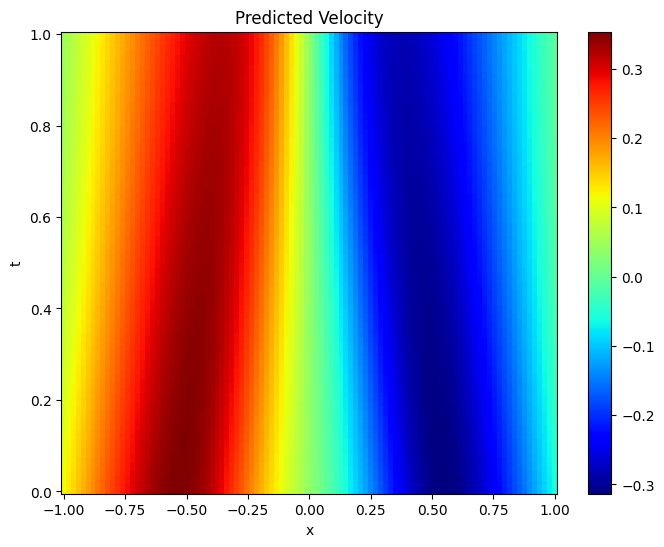

<bound method BaseResourceVariable.numpy of <tf.Variable 'artificial_viscosity:0' shape=() dtype=float32, numpy=0.013432134>>


In [16]:
# v6
# artificial viscosity

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# Define the domain class
class Domain:
    def __init__(self, x_min, x_max, t_min, t_max, num_x, num_t, viscosity_init_v):
        self.x_min = x_min
        self.x_max = x_max
        self.t_min = t_min
        self.t_max = t_max
        self.num_x = num_x
        self.num_t = num_t
        self.viscosity = tf.Variable(initial_value=viscosity_init_v, 
                                     trainable=True, 
                                     dtype=tf.float32,
                                     name="artificial_viscosity")
        # initial value can be tf.random.uniform(shape=(), minval=0.1, maxval=1.0)
    
# Define the initial condition
def initial_condition(domain, x):
    return -np.sin(np.pi * x)

# Define the boundary conditions
def boundary_conditions(domain, x_boundary, x, t):
    return np.zeros_like(x)

# Define the physics-informed loss function
def physics_informed_loss(network, domain, x, t, collocation_points):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(x)
        tape.watch(t)
        
        u = network(tf.concat([x, t], axis=1))

        # solved: not fit to tensor - changed input layer shape into (2,) for 
        # two features #
        u_x = tape.gradient(u, x) # cancel: Reshape x to [32,1]
        u_t = tape.gradient(u, t) # solved: u_t showed NoneType

        # Debugging: Check if any tensors contain NaN values
        tf.debugging.assert_all_finite(u_x, "u_x contains NaN values")
        tf.debugging.assert_all_finite(u_t, "u_t contains NaN values")

        # Define the Burgers equation residual
        residual = u_t + u * u_x - domain.viscosity * tape.gradient(u_x, x)

    # preliminary check
    # print("u:", u) #TODO: suddenly print(u) shows from 
    # u: Tensor("sequential_22/dense_68/BiasAdd:0", shape=(32, 1), dtype=float32)
    # to printable Tensor
    
    # Define the boundary and initial condition residuals
    initial_residual = u - initial_condition(domain, x)
    lower_boundary_residual = u - boundary_conditions(domain, domain.x_min, x, t)
    upper_boundary_residual = u - boundary_conditions(domain, domain.x_max, x, t)

    viscosity_loss = tf.square(domain.viscosity - 0.01)  # Ground truth viscosity is 0.01

    loss = tf.reduce_mean(tf.square(residual)) + \
           tf.reduce_mean(tf.square(initial_residual)) + \
           tf.reduce_mean(tf.square(lower_boundary_residual)) + \
           tf.reduce_mean(tf.square(upper_boundary_residual)) + \
            viscosity_loss
    
    return loss

# Define the neural network model
def create_network():
    network = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(2,)),
        tf.keras.layers.Dense(32, activation='tanh'),
        tf.keras.layers.Dense(32, activation='tanh'),
        tf.keras.layers.Dense(1)
    ])
    return network

# Train the model using PINNs
def train_model(network, domain, num_epochs, learning_rate, batch_size, num_collocation_points):
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    # Generate collocation points
    collocation_points_x = tf.random.uniform([num_collocation_points, 1], minval=domain.x_min, maxval=domain.x_max)
    collocation_points_t = tf.random.uniform([num_collocation_points, 1], minval=domain.t_min, maxval=domain.t_max)
    collocation_points = tf.concat([collocation_points_x, collocation_points_t], axis=1)

    for epoch in range(num_epochs):
        x_batch = tf.random.uniform([batch_size, 1], minval=domain.x_min, maxval=domain.x_max)
        t_batch = tf.random.uniform([batch_size, 1], minval=domain.t_min, maxval=domain.t_max)
        
        # Concatenate x_batch and t_batch to create input with shape (batch_size, 2)

        # input_batch = tf.concat([x_batch, t_batch], axis=1)

        with tf.GradientTape() as tape:
            loss = physics_informed_loss(network, domain, x_batch, t_batch, collocation_points)

        gradients = tape.gradient(loss, network.trainable_variables)
        optimizer.apply_gradients(zip(gradients, network.trainable_variables))

        # try#1 Update the viscosity value during training
        # domain.viscosity.assign(network.layers[-1].weights[0].numpy())

        # try#2
        # Manually update the trainable_viscosity variable based on gradients
        viscosity_update = tf.reduce_sum(learning_rate * gradients[-1])
        # print("shape of nu:", domain.viscosity)
        # print("update.numpy:", viscosity_update.shape)
        domain.viscosity.assign_sub(viscosity_update)  # Update the last gradient element

        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss.numpy()}")
    
    # check shape of nu and assigned value
    print("shape of nu:", domain.viscosity)
    for grad in gradients[-1]:
        grad_s = learning_rate * grad
        print(grad_s.shape)
    return network # worked after changing it to "network"???
    #TODO: showed me the NameError before: NameError                                 Traceback (most recent call last)
# /Users/e0919678/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Desktop/MEng_files/CFD_HPC/Code_TensorDiffEq/burgers_learn_2Oct_v2.ipynb Cell 1 line 1
#     139 network = create_network()
#     141 # Train the model using PINNs
# --> 142 model = train_model(network, domain, num_epochs=2000, learning_rate=0.01, batch_size=32, num_collocation_points=1000)
#     144 # Visualize the results
#     145 visualize_results(model, domain)
# 
# /Users/e0919678/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Desktop/MEng_files/CFD_HPC/Code_TensorDiffEq/burgers_learn_2Oct_v2.ipynb Cell 1 line 1
#     106     if epoch % 100 == 0:
#     107         print(f"Epoch {epoch}, Loss: {loss.numpy()}")
# --> 109 return model
# 
# NameError: name 'model' is not defined

# Visualize the results
def visualize_results(model, domain):
    x_grid, t_grid = np.meshgrid(np.linspace(domain.x_min, domain.x_max, domain.num_x),
                                 np.linspace(domain.t_min, domain.t_max, domain.num_t))
    X = np.hstack((x_grid.flatten()[:, np.newaxis], t_grid.flatten()[:, np.newaxis]))
    u_pred_grid = model.predict(X)
    u_pred_grid = griddata(X, u_pred_grid.flatten(), (x_grid, t_grid), method='cubic')

    plt.figure(figsize=(8, 6))
    plt.pcolor(x_grid, t_grid, u_pred_grid, cmap='jet')
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('t')
    plt.title('Predicted Velocity')
    plt.show()

if __name__ == "__main__":
    # Define domain parameters and create the domain
    x_min = -1.0
    x_max = 1.0
    t_min = 0
    t_max = 1.00
    num_x = 100
    num_t = 100
    viscosity_init_v = 0.01
    domain = Domain(x_min, x_max, t_min, t_max, num_x, num_t, viscosity_init_v)

    # Create the neural network 
    network = create_network()

    # Train the model using PINNs
    model = train_model(network, domain, num_epochs=2000, learning_rate=0.01, batch_size=32, num_collocation_points=1000)

    # Visualize the results
    visualize_results(model, domain)

    print(domain.viscosity.numpy)


Epoch 0, Loss: 0.6465399861335754
Epoch 100, Loss: 0.34642893075942993
Epoch 200, Loss: 0.32757139205932617
Epoch 300, Loss: 0.331623911857605
Epoch 400, Loss: 0.2802187204360962
Epoch 500, Loss: 0.3330795168876648
Epoch 600, Loss: 0.29023027420043945
Epoch 700, Loss: 0.2920212149620056
Epoch 800, Loss: 0.348239541053772
Epoch 900, Loss: 0.36458244919776917
Epoch 1000, Loss: 0.3199272155761719
Epoch 1100, Loss: 0.326090544462204
Epoch 1200, Loss: 0.3067893981933594
Epoch 1300, Loss: 0.35096096992492676
Epoch 1400, Loss: 0.2583686411380768
Epoch 1500, Loss: 0.23692891001701355
Epoch 1600, Loss: 0.39085981249809265
Epoch 1700, Loss: 0.3368171155452728
Epoch 1800, Loss: 0.3577137589454651
Epoch 1900, Loss: 0.34956881403923035
313/313 [==============================] - 0s 313us/step


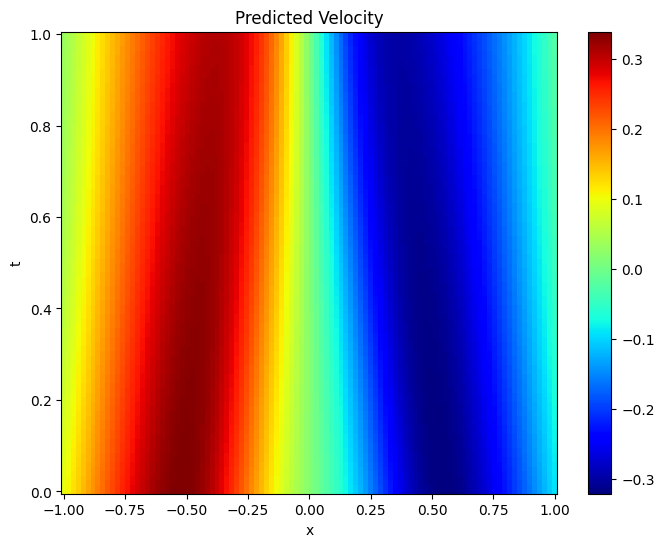

In [2]:
# v5 
# study the name 
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# Define the domain class
class Domain:
    def __init__(self, x_min, x_max, t_min, t_max, num_x, num_t, viscosity_init_v):
        self.x_min = x_min
        self.x_max = x_max
        self.t_min = t_min
        self.t_max = t_max
        self.num_x = num_x
        self.num_t = num_t
        self.viscosity = viscosity_init_v

# Define the initial condition
def initial_condition(domain, x):
    return -np.sin(np.pi * x)

# Define the boundary conditions
def boundary_conditions(domain, x_boundary, x, t):
    return np.zeros_like(x)

# Define the physics-informed loss function
def physics_informed_loss(network, domain, x, t, collocation_points):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(x)
        tape.watch(t)
        
        u = network(tf.concat([x, t], axis=1))
        #print("u:",u)
        #print("u_shape:", u.shape)

        #print("x:", x)
        #print("x_reshape:", x.shape) # no longer need to reshape after inputting x
                                     # and t directly
        #print("t:", t)
        #print("t_reshape:", t.shape)


        #### still not fit to tensor ####
        u_x = tape.gradient(u, x) # cancel: Reshape x to [32,1]
        u_t = tape.gradient(u, t) # solved: u_t showed NoneType

        #print("u_x:", u_x)
        #print("u_t:", u_t)

        # Debugging: Check if any tensors contain NaN values
        tf.debugging.assert_all_finite(u_x, "u_x contains NaN values")
        tf.debugging.assert_all_finite(u_t, "u_t contains NaN values")

        # Define the Burgers equation residual
        residual = u_t + u * u_x - domain.viscosity * tape.gradient(u_x, x)

    # preliminary check
    # print("u:", u) #TODO: suddenly print(u) shows from 
    # u: Tensor("sequential_22/dense_68/BiasAdd:0", shape=(32, 1), dtype=float32)
    # to printable Tensor
    
    # Define the boundary and initial condition residuals
    initial_residual = u - initial_condition(domain, x)
    lower_boundary_residual = u - boundary_conditions(domain, domain.x_min, x, t)
    upper_boundary_residual = u - boundary_conditions(domain, domain.x_max, x, t)

    loss = tf.reduce_mean(tf.square(residual)) + \
           tf.reduce_mean(tf.square(initial_residual)) + \
           tf.reduce_mean(tf.square(lower_boundary_residual)) + \
           tf.reduce_mean(tf.square(upper_boundary_residual))

    return loss


# Define the neural network model
def create_network():
    network = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(2,)),
        tf.keras.layers.Dense(32, activation='tanh'),
        tf.keras.layers.Dense(32, activation='tanh'),
        tf.keras.layers.Dense(1)
    ])
    return network

# Train the model using PINNs
def train_model(network, domain, num_epochs, learning_rate, batch_size, num_collocation_points):
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    # Generate collocation points
    collocation_points_x = tf.random.uniform([num_collocation_points, 1], minval=domain.x_min, maxval=domain.x_max)
    collocation_points_t = tf.random.uniform([num_collocation_points, 1], minval=domain.t_min, maxval=domain.t_max)
    collocation_points = tf.concat([collocation_points_x, collocation_points_t], axis=1)

    for epoch in range(num_epochs):
        x_batch = tf.random.uniform([batch_size, 1], minval=domain.x_min, maxval=domain.x_max)
        t_batch = tf.random.uniform([batch_size, 1], minval=domain.t_min, maxval=domain.t_max)
        
        # Concatenate x_batch and t_batch to create input with shape (batch_size, 2)

        # input_batch = tf.concat([x_batch, t_batch], axis=1)

        with tf.GradientTape() as tape:
            loss = physics_informed_loss(network, domain, x_batch, t_batch, collocation_points)

        gradients = tape.gradient(loss, network.trainable_variables)
        optimizer.apply_gradients(zip(gradients, network.trainable_variables))

        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss.numpy()}")

    return network # worked after changing it to "network"???
    #TODO: showed me the NameError before: NameError                                 Traceback (most recent call last)
# /Users/e0919678/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Desktop/MEng_files/CFD_HPC/Code_TensorDiffEq/burgers_learn_2Oct_v2.ipynb Cell 1 line 1
#     139 network = create_network()
#     141 # Train the model using PINNs
# --> 142 model = train_model(network, domain, num_epochs=2000, learning_rate=0.01, batch_size=32, num_collocation_points=1000)
#     144 # Visualize the results
#     145 visualize_results(model, domain)
# 
# /Users/e0919678/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Desktop/MEng_files/CFD_HPC/Code_TensorDiffEq/burgers_learn_2Oct_v2.ipynb Cell 1 line 1
#     106     if epoch % 100 == 0:
#     107         print(f"Epoch {epoch}, Loss: {loss.numpy()}")
# --> 109 return model
# 
# NameError: name 'model' is not defined

# Visualize the results
def visualize_results(model, domain):
    x_grid, t_grid = np.meshgrid(np.linspace(domain.x_min, domain.x_max, domain.num_x),
                                 np.linspace(domain.t_min, domain.t_max, domain.num_t))
    X = np.hstack((x_grid.flatten()[:, np.newaxis], t_grid.flatten()[:, np.newaxis]))
    u_pred_grid = model.predict(X)
    u_pred_grid = griddata(X, u_pred_grid.flatten(), (x_grid, t_grid), method='cubic')

    plt.figure(figsize=(8, 6))
    plt.pcolor(x_grid, t_grid, u_pred_grid, cmap='jet')
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('t')
    plt.title('Predicted Velocity')
    plt.show()

if __name__ == "__main__":
    # Define domain parameters and create the domain
    x_min = -1.0
    x_max = 1.0
    t_min = 0
    t_max = 1.00
    num_x = 100
    num_t = 100
    viscosity_init_v = 0.01
    domain = Domain(x_min, x_max, t_min, t_max, num_x, num_t, viscosity_init_v)

    # Create the neural network 
    network = create_network()

    # Train the model using PINNs
    model = train_model(network, domain, num_epochs=2000, learning_rate=0.01, batch_size=32, num_collocation_points=1000)

    # Visualize the results
    visualize_results(model, domain)
